# Feature Engineering (sprint 2) | Jupyters | GIA
Nosso processo de feature engineering foi composto de duas partes: primeiro, a otimização dos arquivos --- através da anonimização dos dados, transformação em CSVs, deleção de colunas necessárias e compilação de dados em uma única planilha --- para diminuir o tempo de acesso aos dados no código e facilitar a visualização dos atributos disponíveis. Depois, utilizamos esses arquivos simplificados para idealizar, implementar e testar diferentes conjuntos de features, como detalharemos neste notebook. Por fim, analisamos os resultados e criamos novas hipóteses a serem testadas nas próximas sprints, a fim de melhorar nossas métricas de sucesso.

## Pré-processamento dos dados
Os passos descritos abaixo referem-se às manipulações efetuadas para explorar dados, gerar gráficos e decidir quais features utilizar em nosso projeto. Nesse sentido, o objetivo era diminuir o tempo de processamento das planilhas no código, eliminar informações desnecessárias e formatar certos dados para otimizar filtros e diferentes visualizações antes de selecionar features.

### Anonimização dos dados
Recebemos duas planilhas em formato XLSX que agrupam dados coletados pelo Kantar IBOPE Media a partir de um aparelho de depuração de audiência chamado “People Meter”. O primeiro arquivo, denominado “TV_Histórico”, contém 18 abas elencando dados de audiência por emissora e dia da semana. Mais especificamente, cada emissora é dividida em três abas: uma para dias úteis, uma para sábado e uma para domingo em um período de dois anos (2020-2022), detalhado de 5 em 5 minutos.

Já o segundo arquivo, “grade_Diária_06_2020_a_06_2022.xlsx”, traz uma coluna “Praça”, correspondente ao local de transmissão, “Data”, “Faixa Horária” e uma coluna para cada emissora, contendo a programação para cada slot de junho de 2020 a junho de 2022. 

Nesse sentido, dado que esses dados e, principalmente, as associações emissora são sensíveis, realizamos um processo de anonimização sobre os arquivos antes de adicioná-los ao Google Drive e a este Colab.

Este processo teve duas etapas:
1. No arquivo "TV_Histórico", substituímos todas as menções a emissoras por codinomes seguindo padrão "Emissora A", "Emissora B" e "Emissora C".
2. No arquivo de grade diária, não só realizamos as mesmas substituições de nomes de emissoras como também transformamos os títulos dos programas em "PROGRAMA 1", "PROGRAMA 2", "PROGRAMA 3", e por aí vai. Deve-se mencionar que esse método repete codinomes quando o programa em si se repete (por exemplo, um evento de jornalismo diário denominado "PROGRAMA 56" será substituído por esse codinome todos os dias na planilha), mas que a numeração reinicia a cada emissora (ou seja, "PROGRAMA 56" corresponde a programas diferentes em diferentes emissoras). Por fim, o arquivo original trazia programas e gêneros concatenados em uma única coluna, no formato "PROGRAMA / CATEGORIA". Porém, para facilitar a anonimização dos programas, segregamos, desde o início, essas informações em duas colunas para cada emissora: "EMISSORA X (Programa)" e "EMISSORA X (Categoria)".

Após isso, subimos os dois arquivos resultantes, agora renomeados "audiência_original.xlsx" e "grade.xlsx", respectivamente, na subpasta "0_arquivos_originais", disponível na pasta ["Feature Engineering"](https://drive.google.com/drive/u/3/folders/1s8obHq_dfKkar6zOHj-unaX4aPyHathx) do Drive do grupo Jupyters.

### Transformação dos arquivos Excel em CSVs

> A partir deste ponto, começamos a manipular os arquivos no Colab através dos caminhos do Google Drive. Portanto, faz-se necessário já importar algumas bibliotecas muito utilizadas neste notebook. Para reproduzir todos os caminhos, entretanto, é necessário estar logado na conta do grupo Jupyters, cujas credenciais foram enviadas separadamente para o orientador de turma e professor de Programação. Ainda assim, é possível acompanhar os resultados de cada etapa através 

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Feito isso, podemos começar a tratar os arquivos com o auxílio de código Python.

Primeiramente, o documento “TV_Histórico.xlsx”, mesmo após os processos de anonimização, continha cerca de um milhão de linhas quando somadas todas as suas abas. Logo, o carregamento desse arquivo no código demandava muito tempo e recursos computacionais, além de gerar dataframes mais difíceis de manipular. Portanto, nossa próxima ação em preparar os dados foi separar esse documento Excel em dezoito arquivos CSV, um para cada uma de suas abas. As planilhas resultantes, por sua vez, foram todas salvas na subpasta "1_csv_originais".

In [ ]:
# Esta célula contém um array com o nome de todas as abas do arquivo anonimizado.
sheets_array = ['TLE - Seg a Sex', 'TLE - Sáb', 'TLE - Dom', 
                'Emissora A - Seg a Sex', 'Emissora A - Sáb', 'Emissora A - Dom', 
                'Emissora B - Seg a Sex', 'Emissora B - Sáb', 'Emissora B - Dom', 
                'Emissora C - Seg a Sex', 'Emissora C - Sáb', 'Emissora C - Dom', 
                'Canais Pagos (OCP) - Seg a Sex', 'Canais Pagos (OCP) - Sáb', 'Canais Pagos (OCP) - Dom', 
                'NI Conteúdo - Seg a Sex', 'NI Conteúdo - Sáb', 'NI Conteúdo - Dom']

In [ ]:
# Esta célula define uma função que recebe o nome de uma aba, procura essa aba 
# no arquivo de audiências originais e a salva como CSV. 

def to_csv(sheet):
  
    # O parâmetro 'sheet_name' permite a especificação da aba a ser aberta.
    original_sheet = pd.read_excel('/content/drive/MyDrive/FeatureEngineering/' +
                                   '0_arquivos_originais/audiencia_original.xlsx', 
                                   sheet_name=sheet)
    # O parâmetro index=False impede a criação de uma nova coluna com os indexes 
    # do dataframe, enquanto o encoding='utf-8' evita que conflitos de codificação
    # aconteçam mais para frente, dado que sempre salvaremos e abriremos CSVs com
    # UTF-8.
    original_sheet.to_csv('/content/drive/MyDrive/FeatureEngineering/1_csv_originais/' +
                          sheet + '.csv', index=False, encoding='utf-8') 
    
    print(sheet + " feita!")

In [ ]:
# Cria um loop que passa todos os nomes de aba do array inicial para essa função.
# Dividimos o processo por abas para facilitar a resolução de possíveis bugs, 
# dado que a abertura do arquivo inteiro demoraria demais e exigiria o recomeço de
# toda a operação a cada erro. Com o array, podemos especificar a transformação 
# de abas específicas que não deram certo.
for sheet in sheets_array:
  to_csv(sheet)

KeyboardInterrupt: ignored

Por fim, para evitar problemas de codificação, fizemos o mesmo com o arquivo "grade.xlsx". Caso contrário, 

In [ ]:
# Abre o arquivo de grade e o salva na variável 'grid'. Nenhuma aba é especificada porque só uma existe.
grid = pd.read_excel('/content/drive/MyDrive/FeatureEngineering/0_arquivos_originais/grade.xlsx')
# Salva a dataframe como CSV seguindo padrões de indexing e codificação já discutidos.
grid.to_csv('/content/drive/MyDrive/FeatureEngineering/1_csv_originais/grade.csv', index=False, encoding='utf-8')
print("Feito!")

Feito!


### Remoção de colunas desnecessárias

Nas primeiras reuniões com o parceiro, entendemos que a medição de audiência mais relevante era o "Rat", representando o score de audiência. Por isso, durante a sprint 2, manipulamos os arquivos a fim de eliminar todas as colunas que não contemplassem essa métrica, como as de "Fid", "Shr" e "Rch". No workshop final da sprint, entretanto, o parceiro sugeriu considerar também essas features nos próximos modelos. Portanto, apesar dos processos descritos neste notebook desconsiderarem esses atributos, resolvemos detalhá-los mesmo assim para fins de registro. Nas próximas sprints, pretendemos adicionar essas medições nos modelos a serem testados. Até lá, demonstramos a remoção destas nas células abaixo. Os arquivos resultantes foram salvos na subpasta "2_csv_simplificados".

In [ ]:
# Define array de colunas a serem mantidas no arquivo (excluindo as consideradas pouco relevantes)
columns_array = ['Data', 'Hora Início', 'Dia da Semana',
       'Total Domicílios | Rat%', 'AB | Rat%', 'C1 | Rat%', 'C2 | Rat%',
       'DE | Rat%', 'Masculino | Rat%', 'Feminino | Rat%', '4-11 anos | Rat%',
       '12-17 anos | Rat%', '18-24 anos | Rat%', '25-34 anos | Rat%',
       '35-49 anos | Rat%', '50-59 anos | Rat%', '60+ anos | Rat%']

In [ ]:
# Esta função recebe o nome de uma planilha, abre o arquivo correspondente na pasta de
# CSVs transformados e salve uma nova planilha apenas com as colunas desejadas. 
def drop(sheet):

  # Como mantemos o nome das abas constante, podemos utilizar o mesmo array 
  # durante todo o notebook e só ir mudando o nome das pastas
  modified_sheet = pd.read_csv('/content/drive/MyDrive/FeatureEngineering/' + 
                               '1_csv_originais/' + sheet + '.csv')
  # Selecionamos apenas as colunas desejadas e salvamos essa nova dataframe
  # na variável original
  modified_sheet = modified_sheet[columns_array]
  
  # Novamente, mantemos o padrão de index e encoding
  modified_sheet.to_csv('/content/drive/MyDrive/FeatureEngineering/' + 
                        '2_csv_simplificados/' + sheet + '.csv', 
                        index=False, encoding='utf-8')
  print(sheet + " feito!")

In [ ]:
# Este loop passa todas as abas para a função.
for sheet in sheets_array:
  drop(sheet)

TLE - Seg a Sex feito!
TLE - Sáb feito!
TLE - Dom feito!
Emissora A - Seg a Sex feito!
Emissora A - Sáb feito!
Emissora A - Dom feito!
Emissora B - Seg a Sex feito!
Emissora B - Sáb feito!
Emissora B - Dom feito!
Emissora C - Seg a Sex feito!
Emissora C - Sáb feito!
Emissora C - Dom feito!
Canais Pagos (OCP) - Seg a Sex feito!
Canais Pagos (OCP) - Sáb feito!
Canais Pagos (OCP) - Dom feito!
NI Conteúdo - Seg a Sex feito!
NI Conteúdo - Sáb feito!
NI Conteúdo - Dom feito!


### Junção cronológica das planilhas de cada emissora

O treinamento de um modelo de predição exige a organização dos dados de entrada em arrays organizados. Para facilitar essa seleção de inputs, juntamos as planilhas de cada emissora (inicialmente separadas em dias úteis, sábados e domingos) em uma única planilha para cada canal, seguindo a ordem cronológica. Assim, torna-se possível acessar e filtrar todos os dados relevantes a partir de uma única dataframe. Os resultados foram salvos na subpasta "3_ordem_cronologica". Note que isso só foi feito com três planilhas porque, pela nossa análise, as emissoras são os fatores mais importantes em nosso projeto quando comparadas ao TLE, NI e Canais Pagos, dado que elas incluem e oferecem a maior concorrência ao parceiro.

In [ ]:
# Define o nome das emissoras
channels = ['Emissora A', 'Emissora B', 'Emissora C']

In [ ]:
# Esta função recebe o nome de uma emissora, abre todas as planilhas relacionadas a ela, 
# faz a concatenação e depois reoderna a planilha resultante em ordem cronológica.
# Por fim, salva o resultado na pasta correta.

def join_all_days(sheet):

  # Abre a planilha de dias úteis.
  week = pd.read_csv('/content/drive/MyDrive/FeatureEngineering/2_csv_simplificados/' + sheet + ' - Seg a Sex.csv')
  # Abre a planilha de sábados.
  saturday = pd.read_csv('/content/drive/MyDrive/FeatureEngineering/2_csv_simplificados/' + sheet + ' - Sáb.csv')
  # Abre a planilha de domingos.
  sunday = pd.read_csv('/content/drive/MyDrive/FeatureEngineering/2_csv_simplificados/' + sheet + ' - Dom.csv')

  # Concatena as três dataframes
  concatenated = pd.concat([week, saturday, sunday])

  # Substitui os valores da coluna "Data" por objetos datetime do Python. Isso permite
  # a ordenação cronológica do que antes eram strings.
  concatenated['Data'] = pd.to_datetime(concatenated['Data'])

  # Ordena os dados cronologicamente por data e depois alfabeticamente pela hora de início.
  # Como as horas estão em formato de string, mas seguem, por definição, a ordem numérica 
  # (de 6 a 29), a ordenação alfabética corresponde à cronológica, de modo que não
  # precisamos necessariamente converter o tipo.
  sorted = concatenated.sort_values(by=['Data', "Hora Início"])

  # Salva a dataframe resultante
  sorted.to_csv('/content/drive/MyDrive/FeatureEngineering/3_ordem_cronologica/' + sheet + ".csv", encoding='utf-8', index=False)
  print(sheet + " feita!")

In [ ]:
# Aplica a função às emissoras desejadas
for channel in channels:
  join_all_days(channel)

Emissora A feito!
Emissora B feito!
Emissora C feito!


### Junção com grade horária
Para fins de predição de score de audiência para certo tipo de programa, é essencial que nossos dados mapeiem o histórico de audiência com o histórico de grade de horária. Por isso, agregamos os dados da planilha "grade.csv" com as planilhas de cada emissora resultantes das últimas etapas. Isso foi feito através do merge por data e horário, garantindo a combinação correta dos pares slot-programa. O output foi salvo na subpasta "4_merge_com_programas".

In [ ]:
# Abre a grade de horários em CSV
grid_sheet = pd.read_csv('/content/drive/MyDrive/FeatureEngineering/1_csv_originais/grade.csv', encoding='utf-8')

In [ ]:
# Cria array com emissoras desejadas
channels = ['Emissora A', 'Emissora B', 'Emissora C']

In [ ]:
# Esta função recebe o nome de uma emissora, abre o arquivo relacionado, faz um merge
# completo dessa planilha com a grade horária por data e hora de início
# e então elimina as colunas desnecessárias. 
def merge_timetable(current_channel):
  # Abre planilha da emissora
  sheet = pd.read_csv('/content/drive/MyDrive/FeatureEngineering/3_ordem_cronologica/' + current_channel + '.csv', encoding='utf-8')

  # Esta função interna recebe uma linha da planilha, acessa a célula de faixa 
  # horária, no formato 'xx:xx - xx:xx', e então a transforma para o formato 'xx:xx:xx'.
  def format_time(row):
    return row[2][:5] + ":00"

  # Transforma os valores das colunas de data de ambas as planilhas em objetos
  # datetime. Isso facilita a comparação no merge, pois agora teremos objetos do mesmo tipo.
  sheet['Data'] = pd.to_datetime(sheet['Data'])
  grid_sheet['Data'] = pd.to_datetime(grid_sheet['Data'])

  # Padroniza o formato de hora segundo o formato nas planilhas de emissora e o salva
  # numa coluna própria
  grid_sheet['Hora Início'] = grid_sheet.apply(format_time, axis=1)

  # Faz um merge entre as duas planilhas seguindo o modo 'inner', que junta apenas
  # as linhas em que chaves idênticas são encontradas. As chaves, no caso, consistem
  # na data e hora de início, pois a combinação desses dois não permite repetição, 
  # já que o horário em cada dia é único.
  merged_sheet = pd.merge(sheet, grid_sheet, how='inner',
                               left_on=['Data','Hora Início'], 
                               right_on=['Data','Hora Início'])
  
  # O merge traz todas as colunas da planilha de grade para a planinha de emissoras, 
  # incluindo a programação dos outros canais, a coluna 'Praça', etc. Por isso, é necessário
  # juntar as colunas a serem removidas em um array e executar o comando 'drop'.
  columns_to_remove = ['Praça', 'Faixa Horária']

  # Para saber quais emissoras remover, juntamos todas as emissoras existentes e 
  # eliminamos o nome da emissora atual, a que desejamos manter
  other_channels = ['Emissora A', 'Emissora B', 'Emissora C']
  other_channels.remove(current_channel)

  # Agora, resta formatar o nome das emissoras a serem eliminadas, quebrando-as em
  # programa e categoria conforme aparecem na planilha
  for channel in other_channels:
    columns_to_remove.append(channel + ' (Programa)')
    columns_to_remove.append(channel + ' (Categoria)')
    
  # Utilizamos o 'drop' para eliminar as colunas do array
  merged_sheet = merged_sheet.drop(columns=columns_to_remove)

  # Para deixar a planilha menos tumultuada, tiramos o nome da emissora das colunas de programação
  # e deixamos apenas os títulos 'Programa e 'Gênero'
  merged_sheet = merged_sheet.rename(columns={current_channel + ' (Programa)': 'Programa', current_channel + ' (Categoria)': 'Categoria'})

  # Salva dataframe resultante na pasta desejada.
  merged_sheet.to_csv('/content/drive/MyDrive/FeatureEngineering/4_merge_com_programas/' + current_channel + ".csv", encoding='utf-8', index=False)
  
  print(current_channel + " feita!")

In [ ]:
# Passa cada emissora no array channels para a função
for channel in channels:
  merge_timetable(channel)

Emissora A feita!
Emissora B feita!
Emissora C feita!


### Checando se há valores vazios

A checagem de valores nulos, ausentes e/ou vazios foi feita através do método “isnull()”, da biblioteca Pandas. O resultado foi falso para as três planilhas de emissoras. Portanto, não foi necessário nenhum tratamento nesse quesito.

In [ ]:
# Esta função checa a existência de valores vazios em um arquivo de nome 'sheet' 
# na pasta '4_merge_com_programas'
def check_values(sheet):

  # Abre o arquivo em uma variável 'df'
  df = pd.read_csv('/content/drive/MyDrive/FeatureEngineering/4_merge_com_programas/' 
                   + sheet + '.csv', encoding='utf-8')

  # O método isnull() devolve ua dataframe pandas com True ou False para valores nulos.
  # O chaining desse método com o atributo values devolve um numpy array dos valores do dataframe.
  # O any(), por sua vez, devolve True se algum dos valores do array for True, e False do contrário.
  print("Há valores vazios/faltantes em " + sheet + "? " + str(df.isnull().values.any()))


In [ ]:
# Cria array com emissoras desejadas
channels = ['Emissora A', 'Emissora B', 'Emissora C']

In [ ]:
# Passa cada emissora para a função de checagem 
for channel in channels:
  check_values(channel)

,Data,Hora Início,Dia da Semana,Total Domicílios | Rat%,AB | Rat%,C1 | Rat%,C2 | Rat%,DE | Rat%,Masculino | Rat%,Feminino | Rat%,4-11 anos | Rat%,12-17 anos | Rat%,18-24 anos | Rat%,25-34 anos | Rat%,35-49 anos | Rat%,50-59 anos | Rat%,60+ anos | Rat%,Programa,Categoria
0,2020-06-01,06:00:00,Segunda,4.27,2.40,0.31,0.82,5.23,1.65,2.35,0.0,0.00,0.00,3.19,1.98,5.81,1.61,PROGRAMA 28,JORNALISMO
1,2020-06-01,06:05:00,Segunda,4.89,3.02,0.51,1.08,5.23,1.89,2.75,0.0,0.00,0.00,3.19,2.86,5.81,2.38,PROGRAMA 28,JORNALISMO
2,2020-06-01,06:10:00,Segunda,5.74,3.13,1.53,1.22,5.23,1.97,3.24,0.0,1.22,0.00,3.19,3.52,5.81,2.62,PROGRAMA 28,JORNALISMO
3,2020-06-01,06:15:00,Segunda,6.55,3.06,1.86,1.48,6.46,1.92,3.92,0.0,1.52,0.00,3.19,4.05,6.65,3.10,PROGRAMA 28,JORNALISMO
4,2020-06-01,06:20:00,Segunda,7.27,3.49,2.18,1.48,6.46,2.23,4.05,0.0,1.52,0.00,3.19,4.82,6.90,3.10,PROGRAMA 28,JORNALISMO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218875,2022-06-30,29:35:00,Quinta,1.67,0.30,0.41,1.03,0.53,0.17,0.92,0.0,0.96,0.25,0.00,1.41,0.00,0.71,PROGRAMA 136,JORNALISMO
218876,2022-06-30,29:40:00,Quinta,1.97,0.30,0.41,1.45,0.35,0.17,1.07,0.0,0.96,1.25,0.00,1.41,0.00,0.47,PROGRAMA 136,JORNALISMO
218877,2022-06-30,29:45:00,Quinta,2.22,0.30,0.41,1.45,0.88,0.17,1.26,0.0,0.96,1.25,0.00,1.41,0.00,1.18,PROGRAMA 136,JORNALISMO
218878,2022-06-30,29:50:00,Quinta,2.71,0.54,0.41,1.81,0.88,0.37,1.42,0.0,0.96,1.25,0.00,1.74,0.00,1.88,PROGRAMA 136,JORNALISMO


Há valores vazios/faltantes em Emissora A? False


,Data,Hora Início,Dia da Semana,Total Domicílios | Rat%,AB | Rat%,C1 | Rat%,C2 | Rat%,DE | Rat%,Masculino | Rat%,Feminino | Rat%,4-11 anos | Rat%,12-17 anos | Rat%,18-24 anos | Rat%,25-34 anos | Rat%,35-49 anos | Rat%,50-59 anos | Rat%,60+ anos | Rat%,Programa,Categoria
0,2020-06-01,06:00:00,Segunda,0.20,0.00,0.0,0.0,0.38,0.00,0.13,0.0,0.0,0.00,0.0,0.00,0.00,0.45,PROGRAMA 132,RELIGIOSO
1,2020-06-01,06:05:00,Segunda,0.50,0.00,0.0,0.0,0.95,0.00,0.32,0.0,0.0,0.00,0.0,0.00,0.00,1.13,PROGRAMA 132,RELIGIOSO
2,2020-06-01,06:10:00,Segunda,0.30,0.00,0.0,0.0,0.57,0.00,0.19,0.0,0.0,0.00,0.0,0.00,0.00,0.68,PROGRAMA 132,RELIGIOSO
3,2020-06-01,06:15:00,Segunda,0.36,0.40,0.0,0.0,0.00,0.28,0.00,0.0,0.0,0.00,0.0,0.57,0.00,0.00,PROGRAMA 132,RELIGIOSO
4,2020-06-01,06:20:00,Segunda,0.27,0.31,0.0,0.0,0.00,0.22,0.00,0.0,0.0,0.00,0.0,0.45,0.00,0.00,PROGRAMA 132,RELIGIOSO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218875,2022-06-30,29:35:00,Quinta,0.17,0.43,0.0,0.0,0.00,0.14,0.16,0.0,0.0,0.37,0.0,0.27,0.36,0.00,PROGRAMA 131,RELIGIOSO
218876,2022-06-30,29:40:00,Quinta,0.42,1.09,0.0,0.0,0.00,0.36,0.39,0.0,0.0,0.93,0.0,0.68,0.89,0.00,PROGRAMA 131,RELIGIOSO
218877,2022-06-30,29:45:00,Quinta,0.42,1.09,0.0,0.0,0.00,0.36,0.39,0.0,0.0,0.93,0.0,0.68,0.89,0.00,PROGRAMA 131,RELIGIOSO
218878,2022-06-30,29:50:00,Quinta,0.42,1.09,0.0,0.0,0.00,0.36,0.39,0.0,0.0,0.93,0.0,0.68,0.89,0.00,PROGRAMA 131,RELIGIOSO


Há valores vazios/faltantes em Emissora B? False


,Data,Hora Início,Dia da Semana,Total Domicílios | Rat%,AB | Rat%,C1 | Rat%,C2 | Rat%,DE | Rat%,Masculino | Rat%,Feminino | Rat%,4-11 anos | Rat%,12-17 anos | Rat%,18-24 anos | Rat%,25-34 anos | Rat%,35-49 anos | Rat%,50-59 anos | Rat%,60+ anos | Rat%,Programa,Categoria
0,2020-06-01,06:00:00,Segunda,2.71,0.62,1.29,0.0,4.24,1.63,0.88,0.00,0.0,1.56,0.73,0.88,2.78,2.44,PROGRAMA 131,JORNALISMO
1,2020-06-01,06:05:00,Segunda,2.42,0.00,1.42,0.0,4.05,1.46,0.64,0.00,0.0,1.56,0.91,0.00,2.78,2.21,PROGRAMA 131,JORNALISMO
2,2020-06-01,06:10:00,Segunda,2.42,0.00,1.42,0.0,4.05,1.46,0.64,0.00,0.0,1.56,0.91,0.00,2.78,2.21,PROGRAMA 131,JORNALISMO
3,2020-06-01,06:15:00,Segunda,2.70,0.30,1.42,0.0,4.05,1.68,0.64,0.00,0.0,1.56,0.91,0.00,3.53,2.21,PROGRAMA 131,JORNALISMO
4,2020-06-01,06:20:00,Segunda,2.28,0.53,1.42,0.0,2.02,1.32,0.42,0.00,0.0,1.56,0.91,0.00,1.89,1.82,PROGRAMA 131,JORNALISMO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218875,2022-06-30,29:35:00,Quinta,0.70,0.00,0.00,0.0,5.37,0.26,1.65,4.79,0.0,0.00,1.02,0.00,1.09,0.47,PROGRAMA 159,JORNALISMO
218876,2022-06-30,29:40:00,Quinta,0.78,0.00,0.00,0.0,5.55,0.26,1.71,4.79,0.0,0.00,1.02,0.00,1.09,0.71,PROGRAMA 159,JORNALISMO
218877,2022-06-30,29:45:00,Quinta,0.96,0.60,0.00,0.0,5.02,0.26,1.93,4.79,0.0,0.00,1.02,0.83,1.09,0.00,PROGRAMA 159,JORNALISMO
218878,2022-06-30,29:50:00,Quinta,0.79,0.36,0.00,0.0,5.02,0.26,1.77,4.79,0.0,0.00,1.02,0.50,1.09,0.00,PROGRAMA 159,JORNALISMO


Há valores vazios/faltantes em Emissora C? False


Como podemos ver pelo output do método, não há valores vazios nas planilhas, de modo que não é necessário tratamento especial nesse quesito.

### Checar frequência das categorias

Ainda na busca por outliers e exceções, percebemos que não deveríamos examinar apenas valores absolutos, mas também a frequência de certas variáveis categóricas. Nesse sentido, quisemos garantir que os gêneros de programa mencionados nas planilhas apareciam com frequência suficiente para que conclusões pudessem ser tiradas de forma estatisticamente válida. Por isso, realizamos a contagem de cada categoria presente na grade horária

In [ ]:
# Abre planilha cujo nome é passado no parâmetro, conta os valores de cada gênero
# e os retorna no console.
def get_genre_frequencies(sheet):
  df = pd.read_csv('/content/drive/MyDrive/FeatureEngineering/4_merge_com_programas/' + 
                   sheet + '.csv', encoding='utf-8')

  # Pega coluna de 'Categoria', calcula a contagem de cada valor e transforma o
  # resultado em um dicionário
  counts = df['Categoria'].value_counts().to_dict()
  print(sheet + ": " + str(counts))

In [ ]:
# Cria array com emissoras desejadas
channels = ['Emissora A', 'Emissora B', 'Emissora C']

In [ ]:
# Passa cada emissora para a função
for channel in channels:
  get_genre_frequencies(channel)

Emissora A: {'JORNALISMO': 76440, 'FILME': 41303, 'NOVELA': 30688, 'AUDITORIO': 16288, 'SHOW': 12732, 'ESPORTE': 9417, 'SERIES': 6637, 'REALITY SHOW': 6088, 'FUTEBOL': 4734, 'ENTREVISTA': 3667, 'FEMININO': 2555, 'REPORTAGEM': 2338, 'HUMORISTICO': 1453, 'RELIGIOSO': 1362, 'EDUCATIVO': 982, 'CARROS E MOTORES': 683, 'RURAL': 502, 'MUSICAL': 399, 'POLITICO': 169, 'GAME SHOW': 163, 'CULINARIO': 113, 'MINISSERIE': 70, 'DOCUMENTARIO': 34, 'PREMIACAO': 21, 'DEBATE': 13, 'NAO CONSTA': 12, 'TELE VENDAS': 8, 'OUTROS': 7, 'SORTEIO': 2}
Emissora B: {'JORNALISMO': 84848, 'RELIGIOSO': 44971, 'NOVELA': 20984, 'REPORTAGEM': 11378, 'ENTREVISTA': 10876, 'SHOW': 9562, 'FILME': 8648, 'REALITY SHOW': 7615, 'AUDITORIO': 5010, 'SERIES': 4429, 'FEMININO': 3806, 'INFANTIL': 3222, 'SORTEIO': 1359, 'FUTEBOL': 895, 'ESPORTE': 284, 'HUMORISTICO': 271, 'MUSICAL': 224, 'POLITICO': 169, 'PREMIACAO': 150, 'OUTROS': 69, 'DOCUMENTARIO': 49, 'DEBATE': 36, 'GAME SHOW': 18, 'TELE VENDAS': 5, 'NAO CONSTA': 2}
Emissora C: {'J

Analisando os resultados acima, vemos que algumas categorias possuem frequências baixíssimas, com apenas 2 ou 7 ocorrências. Assim, decidimos eliminar as categorias “NAO CONSTA”, “SORTEIO”, “OUTROS” e “TELE VENDAS”, pois não contêm mais de 12 incidências, no melhor dos casos. Nosso critério para essa decisão foi eliminar todas as categorias até a de “DEBATE”, que traz um aumento relativo de aparições, chegando a 36, e é inerentemente mais relevante às emissoras devido a suas ramificações políticas.


### Eliminação de categorias pouco frequentes

In [ ]:
# Este array define as categorias a serem eliminadas
uncommon_genres = ['NAO CONSTA', 'OUTROS', 'SORTEIO', 'TELE VENDAS']

In [ ]:
# Abre planilha passada na função e elimina linhas cuja categoria se enquadra
# no array de categorias a serem eliminadas
def drop_uncommon_genres(sheet):
  df = pd.read_csv('/content/drive/MyDrive/FeatureEngineering/4_merge_com_programas/' 
                   + sheet + '.csv', encoding='utf-8')
  
  # Este loop passa por cada gênero no array, checa se ele existe na coluna "Categoria"
  # de cada gênero, averigua seu index se isso for verdadeiro e então elimina essa linha.
  # O parâmetro inplace é utilizado para que as alterações sejam feitas na própria planilha.
  for genre in uncommon_genres:
    df.drop(df.index[df['Categoria'] == genre], inplace=True)
  
  # Salva em uma nova pasta
  df.to_csv('/content/drive/MyDrive/FeatureEngineering/5_sem_generos_incomuns/' 
            + sheet + ".csv", encoding='utf-8', index=False)
  print(sheet + " feita!")

In [ ]:
# Cria array com emissoras desejadas
channels = ['Emissora A', 'Emissora B', 'Emissora C']

In [ ]:
# Passa todos os canais para a função
for channel in channels:
  drop_uncommon_genres(channel)

Emissora A feita!


,Data,Hora Início,Dia da Semana,Total Domicílios | Rat%,AB | Rat%,C1 | Rat%,C2 | Rat%,DE | Rat%,Masculino | Rat%,Feminino | Rat%,4-11 anos | Rat%,12-17 anos | Rat%,18-24 anos | Rat%,25-34 anos | Rat%,35-49 anos | Rat%,50-59 anos | Rat%,60+ anos | Rat%,Programa,Categoria
0,2020-06-01,06:00:00,Segunda,4.27,2.40,0.31,0.82,5.23,1.65,2.35,0.0,0.00,0.00,3.19,1.98,5.81,1.61,PROGRAMA 28,JORNALISMO
1,2020-06-01,06:05:00,Segunda,4.89,3.02,0.51,1.08,5.23,1.89,2.75,0.0,0.00,0.00,3.19,2.86,5.81,2.38,PROGRAMA 28,JORNALISMO
2,2020-06-01,06:10:00,Segunda,5.74,3.13,1.53,1.22,5.23,1.97,3.24,0.0,1.22,0.00,3.19,3.52,5.81,2.62,PROGRAMA 28,JORNALISMO
3,2020-06-01,06:15:00,Segunda,6.55,3.06,1.86,1.48,6.46,1.92,3.92,0.0,1.52,0.00,3.19,4.05,6.65,3.10,PROGRAMA 28,JORNALISMO
4,2020-06-01,06:20:00,Segunda,7.27,3.49,2.18,1.48,6.46,2.23,4.05,0.0,1.52,0.00,3.19,4.82,6.90,3.10,PROGRAMA 28,JORNALISMO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218875,2022-06-30,29:35:00,Quinta,1.67,0.30,0.41,1.03,0.53,0.17,0.92,0.0,0.96,0.25,0.00,1.41,0.00,0.71,PROGRAMA 136,JORNALISMO
218876,2022-06-30,29:40:00,Quinta,1.97,0.30,0.41,1.45,0.35,0.17,1.07,0.0,0.96,1.25,0.00,1.41,0.00,0.47,PROGRAMA 136,JORNALISMO
218877,2022-06-30,29:45:00,Quinta,2.22,0.30,0.41,1.45,0.88,0.17,1.26,0.0,0.96,1.25,0.00,1.41,0.00,1.18,PROGRAMA 136,JORNALISMO
218878,2022-06-30,29:50:00,Quinta,2.71,0.54,0.41,1.81,0.88,0.37,1.42,0.0,0.96,1.25,0.00,1.74,0.00,1.88,PROGRAMA 136,JORNALISMO


Emissora B feita!


,Data,Hora Início,Dia da Semana,Total Domicílios | Rat%,AB | Rat%,C1 | Rat%,C2 | Rat%,DE | Rat%,Masculino | Rat%,Feminino | Rat%,4-11 anos | Rat%,12-17 anos | Rat%,18-24 anos | Rat%,25-34 anos | Rat%,35-49 anos | Rat%,50-59 anos | Rat%,60+ anos | Rat%,Programa,Categoria
0,2020-06-01,06:00:00,Segunda,0.20,0.00,0.0,0.0,0.38,0.00,0.13,0.0,0.0,0.00,0.0,0.00,0.00,0.45,PROGRAMA 132,RELIGIOSO
1,2020-06-01,06:05:00,Segunda,0.50,0.00,0.0,0.0,0.95,0.00,0.32,0.0,0.0,0.00,0.0,0.00,0.00,1.13,PROGRAMA 132,RELIGIOSO
2,2020-06-01,06:10:00,Segunda,0.30,0.00,0.0,0.0,0.57,0.00,0.19,0.0,0.0,0.00,0.0,0.00,0.00,0.68,PROGRAMA 132,RELIGIOSO
3,2020-06-01,06:15:00,Segunda,0.36,0.40,0.0,0.0,0.00,0.28,0.00,0.0,0.0,0.00,0.0,0.57,0.00,0.00,PROGRAMA 132,RELIGIOSO
4,2020-06-01,06:20:00,Segunda,0.27,0.31,0.0,0.0,0.00,0.22,0.00,0.0,0.0,0.00,0.0,0.45,0.00,0.00,PROGRAMA 132,RELIGIOSO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218875,2022-06-30,29:35:00,Quinta,0.17,0.43,0.0,0.0,0.00,0.14,0.16,0.0,0.0,0.37,0.0,0.27,0.36,0.00,PROGRAMA 131,RELIGIOSO
218876,2022-06-30,29:40:00,Quinta,0.42,1.09,0.0,0.0,0.00,0.36,0.39,0.0,0.0,0.93,0.0,0.68,0.89,0.00,PROGRAMA 131,RELIGIOSO
218877,2022-06-30,29:45:00,Quinta,0.42,1.09,0.0,0.0,0.00,0.36,0.39,0.0,0.0,0.93,0.0,0.68,0.89,0.00,PROGRAMA 131,RELIGIOSO
218878,2022-06-30,29:50:00,Quinta,0.42,1.09,0.0,0.0,0.00,0.36,0.39,0.0,0.0,0.93,0.0,0.68,0.89,0.00,PROGRAMA 131,RELIGIOSO


Emissora C feita!


,Data,Hora Início,Dia da Semana,Total Domicílios | Rat%,AB | Rat%,C1 | Rat%,C2 | Rat%,DE | Rat%,Masculino | Rat%,Feminino | Rat%,4-11 anos | Rat%,12-17 anos | Rat%,18-24 anos | Rat%,25-34 anos | Rat%,35-49 anos | Rat%,50-59 anos | Rat%,60+ anos | Rat%,Programa,Categoria
0,2020-06-01,06:00:00,Segunda,2.71,0.62,1.29,0.0,4.24,1.63,0.88,0.00,0.0,1.56,0.73,0.88,2.78,2.44,PROGRAMA 131,JORNALISMO
1,2020-06-01,06:05:00,Segunda,2.42,0.00,1.42,0.0,4.05,1.46,0.64,0.00,0.0,1.56,0.91,0.00,2.78,2.21,PROGRAMA 131,JORNALISMO
2,2020-06-01,06:10:00,Segunda,2.42,0.00,1.42,0.0,4.05,1.46,0.64,0.00,0.0,1.56,0.91,0.00,2.78,2.21,PROGRAMA 131,JORNALISMO
3,2020-06-01,06:15:00,Segunda,2.70,0.30,1.42,0.0,4.05,1.68,0.64,0.00,0.0,1.56,0.91,0.00,3.53,2.21,PROGRAMA 131,JORNALISMO
4,2020-06-01,06:20:00,Segunda,2.28,0.53,1.42,0.0,2.02,1.32,0.42,0.00,0.0,1.56,0.91,0.00,1.89,1.82,PROGRAMA 131,JORNALISMO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218875,2022-06-30,29:35:00,Quinta,0.70,0.00,0.00,0.0,5.37,0.26,1.65,4.79,0.0,0.00,1.02,0.00,1.09,0.47,PROGRAMA 159,JORNALISMO
218876,2022-06-30,29:40:00,Quinta,0.78,0.00,0.00,0.0,5.55,0.26,1.71,4.79,0.0,0.00,1.02,0.00,1.09,0.71,PROGRAMA 159,JORNALISMO
218877,2022-06-30,29:45:00,Quinta,0.96,0.60,0.00,0.0,5.02,0.26,1.93,4.79,0.0,0.00,1.02,0.83,1.09,0.00,PROGRAMA 159,JORNALISMO
218878,2022-06-30,29:50:00,Quinta,0.79,0.36,0.00,0.0,5.02,0.26,1.77,4.79,0.0,0.00,1.02,0.50,1.09,0.00,PROGRAMA 159,JORNALISMO


### Checagem de outliers

Para determinar se existem valores muito extremos nos dados que poderiam enviesar o modelo preditivo, tiramos a média e desvio-padrão de cada coluna em cada planilha. Então, conferimos se existia algum valor mais distante da média do que três desvios-padrão, pois este é o critério mais utilizado para identificar outliers.

In [ ]:
def check_outliers_by_std(sheet):
  df = pd.read_csv('/content/drive/MyDrive/FeatureEngineering/5_sem_generos_incomuns/' +
                   sheet + '.csv', encoding='utf-8')
  print(sheet.upper())
  total_outliers = 0
  for column in df.columns[3:11]:
    mean = df[column].mean()
    std = df[column].std()
    count = 0
    for value in df[column]:
      if abs((value - mean) / std) >= 3:
        count += 1
    total_outliers += count
    print('Outliers da coluna ' + column + ': ' + str(count))
  print('Soma de todos os outliers da planilha: ' + str(total_outliers) + '\n\n')

In [ ]:
# Cria array com emissoras desejadas
channels = ['Emissora A', 'Emissora B', 'Emissora C']

In [ ]:
# Passa todos os canais para a função
for channel in channels:
  check_outliers_by_std(channel)

EMISSORA A
Outliers da coluna Total Domicílios | Rat%: 1453
Outliers da coluna AB | Rat%: 1701
Outliers da coluna C1 | Rat%: 2209
Outliers da coluna C2 | Rat%: 2058
Outliers da coluna DE | Rat%: 2454
Outliers da coluna Masculino | Rat%: 1796
Outliers da coluna Feminino | Rat%: 2124
Outliers da coluna 4-11 anos | Rat%: 3214
Soma de todos os outliers da planilha: 17009


EMISSORA B
Outliers da coluna Total Domicílios | Rat%: 739
Outliers da coluna AB | Rat%: 2899
Outliers da coluna C1 | Rat%: 2244
Outliers da coluna C2 | Rat%: 1346
Outliers da coluna DE | Rat%: 2273
Outliers da coluna Masculino | Rat%: 936
Outliers da coluna Feminino | Rat%: 1289
Outliers da coluna 4-11 anos | Rat%: 4260
Soma de todos os outliers da planilha: 15986


EMISSORA C
Outliers da coluna Total Domicílios | Rat%: 1808
Outliers da coluna AB | Rat%: 3166
Outliers da coluna C1 | Rat%: 3406
Outliers da coluna C2 | Rat%: 3718
Outliers da coluna DE | Rat%: 2031
Outliers da coluna Masculino | Rat%: 1926
Outliers da colu

Para avaliar melhor o cenário, decidimos, então, gerar gráficos box-plot de todas as colunas. Esse tipo de gráfico é útil porque explicita não só a média de um dataset como também os percentis 25 e 75, a amplitude dos dados e os outliers de forma muito mais visual e intuitiva. Nesse modelo, outliers são valores além de 1,5 * IQR (a amplitude entre os percentis 25 e 75) da média e geralmente aparecem como pontos isolados acima ou abaixo das caudas do gráfico, o que demonstra sua falta de encaixe com o resto do dataset.

In [ ]:
import matplotlib.pyplot as plt

def show_outlier_analysis(sheet):
  df = pd.read_csv('/content/drive/MyDrive/FeatureEngineering/5_sem_generos_incomuns/' + sheet + '.csv', encoding='utf-8')
  ax = df[df.columns[3:-3]].plot(kind='box', title='Audiências por tipo | ' + sheet, showmeans=True)
  plt.ylabel('Audiência')
  plt.xticks(rotation=90)
  plt.show()

In [ ]:
# Cria array com emissoras desejadas
channels = ['Emissora A', 'Emissora B', 'Emissora C']

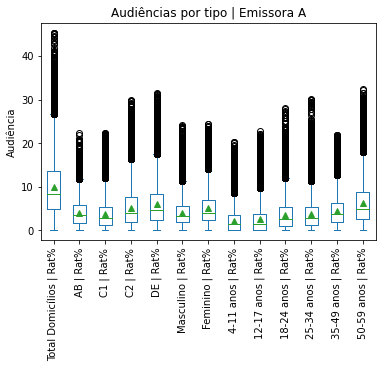

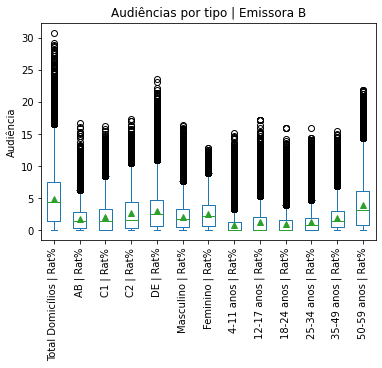

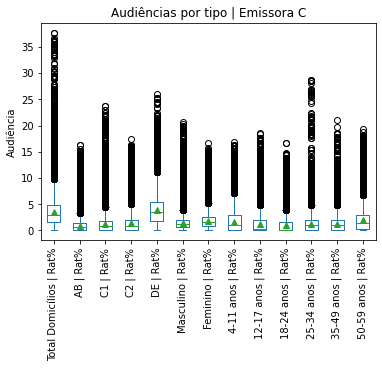

In [ ]:
# Passa todos os canais para a função
for channel in channels:
  show_outlier_analysis(channel)

Ao analisar os gráficos de nossos dados, entretanto, vemos que não há apenas alguns pontos isolados, e sim de uma incidência tão alta de valores extremos que mais parecem uma continuação das caudas do gráfico. Nesse sentido, é fácil visualizar que esses valores formam um padrão distinto no dataset e que eliminá-los descaracterizaria nossos dados. Afinal, outliers são, por definição, exceções. Aqui, é evidente que audiências altas estão longe de serem excepcionais. Nesse contexto, decidimos manter todos os dados, pois não há outliers reais a serem removidos.

## Seleção de features
A finalidade da GIA é clara: prever o score de audiência para futuros programas com certas características (gênero) em certos dias e horários. 

Nesse contexto, iniciamos a seleção pelas datas, pois seriam mais fáceis de manipular e preparar através das bibliotecas do Python. Em nossos estudos prévios, percebemos que o dia do mês não exercia influência significativa nas audiências (vide gráficos da seção anterior), contudo o dia da semana e o mês em si, sim. Assim, determinamos que essas duas informações (dia da semana e mês) deveriam ser contempladas nas features. 

### Mês
Por ser uma característica ordinal, transformamos o mês de cada data em um inteiro de 1 a 12. Para fazer isso, fizemos a conversão da coluna de datas em objetos Python e acessamos o atributo 'month' de cada uma.


In [ ]:
# Abre planilha de nome 'sheet', transforma datas em objetos datetime, guarda
# os meses de cada objeto em um array, a ser salvo como nova coluna. O resultado
# é transformado em CSV.

def segregate_month(sheet):
  df = pd.read_csv('/content/drive/MyDrive/FeatureEngineering/5_sem_generos_incomuns/' + sheet + '.csv', encoding='utf-8')
  # Guarda datas da coluna 'Data' como objetos na variável 'dates'
  dates = pd.to_datetime(df['Data'])
  months = []
  # Este loop adiciona o mês de cada data em um array 'months'
  for date in dates:
    months.append(date.month)
  # Cria coluna 'mês' com array 'months'
  df['Mês'] = months
  # Salva em CSV na pasta correta
  df.to_csv('/content/drive/MyDrive/FeatureEngineering/6_mes_separado/' + sheet + '.csv', encoding='utf-8', index=False)
  print(sheet + " feita!")

In [ ]:
# Cria array com emissoras desejadas
channels = ['Emissora A', 'Emissora B', 'Emissora C']

In [ ]:
# Passa todos os canais para a função
for channel in channels:
  segregate_month(channel)

Emissora A feito!
Emissora B feito!
Emissora C feito!


### Dias da semana
A coluna de dias da semana já trazia esses valores em strings de "Segunda" a "Domingo". Por ser um número pequeno de possibilidades, fizemos o label encoding, ordinal, manualmente.


In [ ]:
# Esta função substitui as strings da coluna 'Dia da Semana' de uma planilha de nome
# 'sheet' com seus correspondentes numéricos (1-7). O resultado é salvo na subpasta
# '7_semana_numerica'.
def encode_week(sheet):
  df = pd.read_csv('/content/drive/MyDrive/FeatureEngineering/6_mes_separado/' + sheet + '.csv', encoding='utf-8')
  # Cria hashmap associando cada dia da semana com um número
  week_encoding = {'Segunda': 1, 'Terça': 2, 'Quarta': 3, 'Quinta': 4, 'Sexta': 5, 'Sábado': 6, 'Domingo': 7}
  # Faz a substituição com base no hashmap
  df['Dia da Semana'] = df['Dia da Semana'].replace(week_encoding)
  df.to_csv('/content/drive/MyDrive/FeatureEngineering/7_semana_numerica/' + sheet + '.csv', encoding='utf-8', index=False)
  print(sheet + " feita!")

In [ ]:
# Cria array com emissoras desejadas
channels = ['Emissora A', 'Emissora B', 'Emissora C']

In [ ]:
# Passa todos os canais para a função
for channel in channels:
  encode_week(channel)

Emissora A feita!
Emissora B feita!
Emissora C feita!


A partir daqui, cada conjunto de features requer transformações específicas das outras entradas. Portanto, decidimos detalhá-las separadamente por hipótese de feature engineering.

### Hipótese 1
> Entradas de dia da semana, mês, categoria cardinal e hora de início de meia em meia hora para a planilha da Emissora A. Saída de Rat%. Predição com regressão linear.

Nesse caso, falta transformar as strings de categoria em números cardinais. Para isso, utilizamos a técnica de one-hot encoding, que atribui 0 e 1 a cada possível valor da variável, seguindo seu status como "Verdadeira" ou "Falsa". 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/FeatureEngineering/7_semana_numerica/' + 'Emissora A' + '.csv', encoding='utf-8')
# Este método transforma os valores únicos de uma coluna em colunas individuais auxiliares,
# seguindo o modelo de one-hot encoding. O parâmetro "prefix" determina o prefixo de cada coluna.
dummies = pd.get_dummies(df['Categoria'], prefix='Categoria')
# Concatena colunas auxiliares com planilha existente
df = pd.concat([df, dummies], axis=1)
# Deleta coluna de categorias original
df.pop('Categoria')
print("Feito!")

Feito!


Além disso, precisamos reduzir a periodização de horas de 5 em 5 minutos para meia em meia hora. Para esse fim, fizemos um hashmap associando as strings de horário com o decimal da meia-hora a que ele pertence. Por exemplo, "06:10:00" torna-se 6 e "08:45:00" torna-se 8,5. Isso é utilizado para substituir os valores na coluna de "Hora Início" e, depois, calcular a média por meia-hora através do método groupby().

In [ ]:
# Define hashmap de horários em 30/30m

timemap = {
    "06:00:00": 6,
    "06:05:00": 6,
    "06:10:00": 6,
    "06:15:00": 6,
    "06:20:00": 6,
    "06:25:00": 6,
    "06:30:00": 6.5,
    "06:35:00": 6.5,
    "06:40:00": 6.5,
    "06:45:00": 6.5,
    "06:50:00": 6.5,
    "06:55:00": 6.5,
    "07:00:00": 7,
    "07:05:00": 7,
    "07:10:00": 7,
    "07:15:00": 7,
    "07:20:00": 7,
    "07:25:00": 7,
    "07:30:00": 7.5,
    "07:35:00": 7.5,
    "07:40:00": 7.5,
    "07:45:00": 7.5,
    "07:50:00": 7.5,
    "07:55:00": 7.5,
    "08:00:00": 8,
    "08:05:00": 8,
    "08:10:00": 8,
    "08:15:00": 8,
    "08:20:00": 8,
    "08:25:00": 8,
    "08:30:00": 8.5,
    "08:35:00": 8.5,
    "08:40:00": 8.5,
    "08:45:00": 8.5,
    "08:50:00": 8.5,
    "08:55:00": 8.5,
    "09:00:00": 9,
    "09:05:00": 9,
    "09:10:00": 9,
    "09:15:00": 9,
    "09:20:00": 9,
    "09:25:00": 9,
    "09:30:00": 9.5,
    "09:35:00": 9.5,
    "09:40:00": 9.5,
    "09:45:00": 9.5,
    "09:50:00": 9.5,
    "09:55:00": 9.5,
    "10:00:00": 10,
    "10:05:00": 10,
    "10:10:00": 10,
    "10:15:00": 10,
    "10:20:00": 10,
    "10:25:00": 10,
    "10:30:00": 10.5,
    "10:35:00": 10.5,
    "10:40:00": 10.5,
    "10:45:00": 10.5,
    "10:50:00": 10.5,
    "10:55:00": 10.5,
    "11:00:00": 11,
    "11:05:00": 11,
    "11:10:00": 11,
    "11:15:00": 11,
    "11:20:00": 11,
    "11:25:00": 11,
    "11:30:00": 11.5,
    "11:35:00": 11.5,
    "11:40:00": 11.5,
    "11:45:00": 11.5,
    "11:50:00": 11.5,
    "11:55:00": 11.5,
    "12:00:00": 12,
    "12:05:00": 12,
    "12:10:00": 12,
    "12:15:00": 12,
    "12:20:00": 12,
    "12:25:00": 12,
    "12:30:00": 12.5,
    "12:35:00": 12.5,
    "12:40:00": 12.5,
    "12:45:00": 12.5,
    "12:50:00": 12.5,
    "12:55:00": 12.5,
    "13:00:00": 13,
    "13:05:00": 13,
    "13:10:00": 13,
    "13:15:00": 13,
    "13:20:00": 13,
    "13:25:00": 13,
    "13:30:00": 13.5,
    "13:35:00": 13.5,
    "13:40:00": 13.5,
    "13:45:00": 13.5,
    "13:50:00": 13.5,
    "13:55:00": 13.5,
    "14:00:00": 14,
    "14:05:00": 14,
    "14:10:00": 14,
    "14:15:00": 14,
    "14:20:00": 14,
    "14:25:00": 14,
    "14:30:00": 14.5,
    "14:35:00": 14.5,
    "14:40:00": 14.5,
    "14:45:00": 14.5,
    "14:50:00": 14.5,
    "14:55:00": 14.5,
    "15:00:00": 15,
    "15:05:00": 15,
    "15:10:00": 15,
    "15:15:00": 15,
    "15:20:00": 15,
    "15:25:00": 15,
    "15:30:00": 15.5,
    "15:35:00": 15.5,
    "15:40:00": 15.5,
    "15:45:00": 15.5,
    "15:50:00": 15.5,
    "15:55:00": 15.5,
    "16:00:00": 16,
    "16:05:00": 16,
    "16:10:00": 16,
    "16:15:00": 16,
    "16:20:00": 16,
    "16:25:00": 16,
    "16:30:00": 16.5,
    "16:35:00": 16.5,
    "16:40:00": 16.5,
    "16:45:00": 16.5,
    "16:50:00": 16.5,
    "16:55:00": 16.5,
    "17:00:00": 17,
    "17:05:00": 17,
    "17:10:00": 17,
    "17:15:00": 17,
    "17:20:00": 17,
    "17:25:00": 17,
    "17:30:00": 17.5,
    "17:35:00": 17.5,
    "17:40:00": 17.5,
    "17:45:00": 17.5,
    "17:50:00": 17.5,
    "17:55:00": 17.5,
    "18:00:00": 18,
    "18:05:00": 18,
    "18:10:00": 18,
    "18:15:00": 18,
    "18:20:00": 18,
    "18:25:00": 18,
    "18:30:00": 18.5,
    "18:35:00": 18.5,
    "18:40:00": 18.5,
    "18:45:00": 18.5,
    "18:50:00": 18.5,
    "18:55:00": 18.5,
    "19:00:00": 19,
    "19:05:00": 19,
    "19:10:00": 19,
    "19:15:00": 19,
    "19:20:00": 19,
    "19:25:00": 19,
    "19:30:00": 19.5,
    "19:35:00": 19.5,
    "19:40:00": 19.5,
    "19:45:00": 19.5,
    "19:50:00": 19.5,
    "19:55:00": 19.5,
    "20:00:00": 20,
    "20:05:00": 20,
    "20:10:00": 20,
    "20:15:00": 20,
    "20:20:00": 20,
    "20:25:00": 20,
    "20:30:00": 20.5,
    "20:35:00": 20.5,
    "20:40:00": 20.5,
    "20:45:00": 20.5,
    "20:50:00": 20.5,
    "20:55:00": 20.5,
    "21:00:00": 21,
    "21:05:00": 21,
    "21:10:00": 21,
    "21:15:00": 21,
    "21:20:00": 21,
    "21:25:00": 21,
    "21:30:00": 21.5,
    "21:35:00": 21.5,
    "21:40:00": 21.5,
    "21:45:00": 21.5,
    "21:50:00": 21.5,
    "21:55:00": 21.5,
    "22:00:00": 22,
    "22:05:00": 22,
    "22:10:00": 22,
    "22:15:00": 22,
    "22:20:00": 22,
    "22:25:00": 22,
    "22:30:00": 22.5,
    "22:35:00": 22.5,
    "22:40:00": 22.5,
    "22:45:00": 22.5,
    "22:50:00": 22.5,
    "22:55:00": 22.5,
    "23:00:00": 23,
    "23:05:00": 23,
    "23:10:00": 23,
    "23:15:00": 23,
    "23:20:00": 23,
    "23:25:00": 23,
    "23:30:00": 23.5,
    "23:35:00": 23.5,
    "23:40:00": 23.5,
    "23:45:00": 23.5,
    "23:50:00": 23.5,
    "23:55:00": 23.5,
    "24:00:00": 24,
    "24:05:00": 24,
    "24:10:00": 24,
    "24:15:00": 24,
    "24:20:00": 24,
    "24:25:00": 24,
    "24:30:00": 24.5,
    "24:35:00": 24.5,
    "24:40:00": 24.5,
    "24:45:00": 24.5,
    "24:50:00": 24.5,
    "24:55:00": 24.5,
    "25:00:00": 25,
    "25:05:00": 25,
    "25:10:00": 25,
    "25:15:00": 25,
    "25:20:00": 25,
    "25:25:00": 25,
    "25:30:00": 25.5,
    "25:35:00": 25.5,
    "25:40:00": 25.5,
    "25:45:00": 25.5,
    "25:50:00": 25.5,
    "25:55:00": 25.5,
    "26:00:00": 26,
    "26:05:00": 26,
    "26:10:00": 26,
    "26:15:00": 26,
    "26:20:00": 26,
    "26:25:00": 26,
    "26:30:00": 26.5,
    "26:35:00": 26.5,
    "26:40:00": 26.5,
    "26:45:00": 26.5,
    "26:50:00": 26.5,
    "26:55:00": 26.5,
    "27:00:00": 27,
    "27:05:00": 27,
    "27:10:00": 27,
    "27:15:00": 27,
    "27:20:00": 27,
    "27:25:00": 27,
    "27:30:00": 27.5,
    "27:35:00": 27.5,
    "27:40:00": 27.5,
    "27:45:00": 27.5,
    "27:50:00": 27.5,
    "27:55:00": 27.5,
    "28:00:00": 28,
    "28:05:00": 28,
    "28:10:00": 28,
    "28:15:00": 28,
    "28:20:00": 28,
    "28:25:00": 28,
    "28:30:00": 28.5,
    "28:35:00": 28.5,
    "28:40:00": 28.5,
    "28:45:00": 28.5,
    "28:50:00": 28.5,
    "28:55:00": 28.5,
    "29:00:00": 29,
    "29:05:00": 29,
    "29:10:00": 29,
    "29:15:00": 29,
    "29:20:00": 29,
    "29:25:00": 29,
    "29:30:00": 29.5,
    "29:35:00": 29.5,
    "29:40:00": 29.5,
    "29:45:00": 29.5,
    "29:50:00": 29.5,
    "29:55:00": 29.5,
}

In [ ]:
# Substitui strings de horas pelo horário decimal de 30 em 30m
df = df.replace({"Hora Início": timemap})

# Define colunas a serem simplificadas para sua média a cada 30m (colunas de audiência)
columns = ['Total Domicílios | Rat%', 'AB | Rat%', 'C1 | Rat%', 'C2 | Rat%',
       'DE | Rat%', 'Masculino | Rat%', 'Feminino | Rat%', '4-11 anos | Rat%',
       '12-17 anos | Rat%', '18-24 anos | Rat%', '25-34 anos | Rat%',
       '35-49 anos | Rat%', '50-59 anos | Rat%', '60+ anos | Rat%']

# Substitui os valores de células com a mesma data e hora de início pela média do
# período de meia-hora em que elas estão inseridas
df[columns] = df.groupby(['Data', 'Hora Início'])[columns].transform('mean')

# Deleta duplicatas para reduzir as linhas. Todas as colunas do array 'columns'
# repetem nos mesmos lugares após o último passo. Assim, escolhemos uma delas para
# ser usada como comparação de duplicatas. Qualquer outra do array funcionaria.
df = df.drop_duplicates(['Total Domicílios | Rat%'])

df.to_csv('/content/drive/MyDrive/FeatureEngineering/hipotese1/' + 'Emissora A' + '.csv', encoding='utf-8', index=False)

Feito isso, isolamos apenas os valores desejados para entradas e saídas deste modelo, criamos os sets para teste e treino, fazemos a regressão e testamos algumas métricas. No caso, utilizamos o erro médio quadrado, que penaliza mais erros maiores; erro médio, que mostra a discrepância média entre valor predito e valor real; e R², que representa a eficácia da hipótese quando comparada a um modelo naive. Nessa última, objetiva-se chegar o mais próximo possível de 1.


In [ ]:
# Importa métodos para separar dataset em treino e teste
from sklearn.model_selection import train_test_split

# Dividindo x e y
y = df['Total Domicílios | Rat%'].values # Score de audiência
x = df[['Hora Início', 'Dia da Semana', 'Mês',
       'Categoria_AUDITORIO', 'Categoria_CARROS E MOTORES',
       'Categoria_CULINARIO', 'Categoria_DEBATE', 'Categoria_DOCUMENTARIO',
       'Categoria_EDUCATIVO', 'Categoria_ENTREVISTA', 'Categoria_ESPORTE',
       'Categoria_FEMININO', 'Categoria_FILME', 'Categoria_FUTEBOL',
       'Categoria_GAME SHOW', 'Categoria_HUMORISTICO', 'Categoria_JORNALISMO',
       'Categoria_MINISSERIE', 'Categoria_MUSICAL', 'Categoria_NOVELA',
       'Categoria_POLITICO', 'Categoria_PREMIACAO', 'Categoria_REALITY SHOW',
       'Categoria_RELIGIOSO', 'Categoria_REPORTAGEM', 'Categoria_RURAL',
       'Categoria_SERIES', 'Categoria_SHOW']].values # Features de data, hora e categoria

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [ ]:
# Importa métodos para fazer regressão linear e testar eficácia dos resultados
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Treinando o modelo
model = LinearRegression().fit(x_train, y_train)

# Testando o modelo
y_pred = model.predict(x_test)

# Avaliando testes
mean_squared = mean_squared_error(y_test, y_pred)
print("Erro médio quadrado: " + str(mean_squared))
mean_absolute = mean_absolute_error(y_test, y_pred)
print("Erro médio: " + str(mean_absolute))
r2 = r2_score(y_test, y_pred)
print("R^2: " + str(r2))

Erro médio quadrado: 32.804852251521474
Erro médio: 4.62607344055152
R^2: 0.4184967210608739


Aqui, o erro médio é de quase 5 pontos de audiência. Para uma amplitude de cerca de 40 pontos, isso é um erro significativo, passando de 10%. Já o R² nem chega a 0,5, mostrando-se insuficiente.

### Hipótese 2
> Entradas de dia da semana, mês, categoria cardinal e hora de início de cinco em cinco minutos para a planilha da Emissora 0. Saída de Rat%. Predição com regressão linear.

Nesse caso, falta transformar as strings de categoria em números cardinais. Para isso, utilizamos a técnica de one-hot encoding, que atribui 0 e 1 a cada possível valor da variável, seguindo seu status como "Verdadeira" ou "Falsa". 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/FeatureEngineering/7_semana_numerica/' + 
                 'Emissora A' + '.csv', encoding='utf-8')

# One-hot encoding da coluna de categoria dos programas, transformando
# cada valor da coluna, que são do tipo string, em novas colunas
# carregando valores cardinais.
dummies = pd.get_dummies(df['Categoria'], drop_first=True, prefix='Categoria')

# Adição das novas colunas de cardinais de categoria e remoção da original.
df = pd.concat([df, dummies], axis=1)
df.pop('Categoria')

0         JORNALISMO
1         JORNALISMO
2         JORNALISMO
3         JORNALISMO
4         JORNALISMO
             ...    
218846    JORNALISMO
218847    JORNALISMO
218848    JORNALISMO
218849    JORNALISMO
218850    JORNALISMO
Name: Categoria, Length: 218851, dtype: object

Além disso, precisamos transformar os horários, que estão em strings de 5 em 5 minutos, em decimais, também nessa periodização.

In [ ]:
# Esta célula transforma o horário em horas decimais, em que cada 5 minutos 
# equivalem a 0,08 horas e sobreescrevem a coluna original 'Hora Início'.

# Salva array de todos os horários, sem duplicatas, da coluna "Hora Início"
hours = df['Hora Início'].unique()
timemap = {}

# Formatação de cada horário do array para horas decimais, a serem salvas
# em um timemap para futura substituição
for hour in hours:
  # Se o horário é inferior a 23, transformamos a string em objeto datetime, 
  # mantemos o atributo hora como inteiro e somamos a fração de minutos para obter
  # o decimal completo.
  if int(hour[:2]) <= 23:
    timemap[hour] = round(pd.to_datetime(hour).hour + pd.to_datetime(hour).minute / 60, 2)
  
  # Os horários da coluna original seguem o intervalo das 06:00:00 às 29:00:00, portanto
  # para as horas que passam do padrão de 24 horas, é calculada a diferença dessa hora
  # por 24.
  else:
    # Para calcular a fração de minutos, criamos uma hora auxiliar baseada na hora real
    # Por exemplo, no horário 29, a hora auxiliar é 29 - 24 = 5
    auxiliary_hour = hour
    # Substituímos a parte da hora (primeiros dois caracteres) da string original pela hora auxiliar
    auxiliary_hour = auxiliary_hour.replace(hour[:2], "0" + str(int(hour[:2]) - 24), 1) # Adicionamos um zero antes da hora para manter o padrão
    # Adiciona ao horário o valor de minutos correspondente à hora decimal (minuto dividido por 60).
    timemap[hour] = round(int(hour[:2]) + pd.to_datetime(auxiliary_hour).minute / 60, 2)

# Substitui valores na coluna Hora Início
df = df.replace({"Hora Início": timemap})

Feito isso, isolamos apenas os valores desejados para entradas e saídas deste modelo, criamos os sets para teste e treino, fazemos a regressão e testamos algumas métricas.

In [ ]:
from sklearn.model_selection import train_test_split

# Dividindo x e y
y = df['Total Domicílios | Rat%'].values
x = df[['Hora Início', 'Dia da Semana', 'Mês',
       'Categoria_CARROS E MOTORES', 'Categoria_CULINARIO', 'Categoria_DEBATE',
       'Categoria_DOCUMENTARIO', 'Categoria_EDUCATIVO', 'Categoria_ENTREVISTA',
       'Categoria_ESPORTE', 'Categoria_FEMININO', 'Categoria_FILME',
       'Categoria_FUTEBOL', 'Categoria_GAME SHOW', 'Categoria_HUMORISTICO',
       'Categoria_JORNALISMO', 'Categoria_MINISSERIE', 'Categoria_MUSICAL',
       'Categoria_NOVELA', 'Categoria_POLITICO', 'Categoria_PREMIACAO',
       'Categoria_REALITY SHOW', 'Categoria_RELIGIOSO', 'Categoria_REPORTAGEM',
       'Categoria_RURAL', 'Categoria_SERIES', 'Categoria_SHOW']].values


# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [ ]:
# Importa métodos para fazer regressão linear e testar eficácia dos resultados
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Treinando o modelo
model = LinearRegression().fit(x_train, y_train)

# Testando o modelo
y_pred = model.predict(x_test)

# Avaliando resultados
mean_squared = mean_squared_error(y_test, y_pred)
print("Erro médio quadrado: " + str(mean_squared))
mean_absolute = mean_absolute_error(y_test, y_pred)
print("Erro médio: " + str(mean_absolute))
r2 = r2_score(y_test, y_pred)
print("R^2: " + str(r2))

df.to_csv('/content/drive/MyDrive/FeatureEngineering/hipotese2/' + 'Emissora A' + '.csv', encoding='utf-8', index=False)

Erro médio quadrado: 24.80568954239913
Erro médio: 3.8310018190852384
R^2: 0.4158580211459625


Para nossa surpresa, esse conjunto de features resultou em erros muito semelhantes, ainda que levemente superiores, aos do modelo anterior. Analisando o fato com mais atenção, percebemos que isso se dá porque a única diferença entre as hipóteses 1 e 2 é o fato de a primeira conter as médias da segunda a cada meia-hora. Logo, elas possuem valores proporcionais, cuja semelhança foi preservada no modelo preditivo. Assim, percebemos que simplesmente mudar a periodização dos horários no futuro não altera significativamente o desempenho do modelo. 

### Hipótese 3

> Entradas de dia da semana, mês, categoria ordinal e hora de início de 30 em 30 minutos para a planilha da Emissora 0. Saída de Rat%. Predição com regressão linear.

Nesse caso, falta transformar as strings de categoria em números ordinais. Para isso, utilizamos a técnica de label encoding, que atribui um inteiro crescente a cada valor possível. Por simplicidade, fizemos isso "manualmente" através de um loop.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/FeatureEngineering/7_semana_numerica/' + 
                 'Emissora A' + '.csv', encoding='utf-8')

# Cria array com valores únicos de categoria
genres = df['Categoria'].unique()
genre_map = {} # Declara hashmap para encoding das categorias
i = 1 # Inicia counter do encoding
# Para cada gênero único da coluna, atribue um valor ordenado
for genre in genres:
  genre_map[genre] = i
  i += 1
# Substitui valores
df = df.replace({"Categoria": genre_map})

Agora, precisamos repetir o processo de transformar os horários em médias de 30 em 30 minutos.

In [ ]:
# Define o hashmap
timemap = {
    "06:00:00": 6,
    "06:05:00": 6,
    "06:10:00": 6,
    "06:15:00": 6,
    "06:20:00": 6,
    "06:25:00": 6,
    "06:30:00": 6.5,
    "06:35:00": 6.5,
    "06:40:00": 6.5,
    "06:45:00": 6.5,
    "06:50:00": 6.5,
    "06:55:00": 6.5,
    "07:00:00": 7,
    "07:05:00": 7,
    "07:10:00": 7,
    "07:15:00": 7,
    "07:20:00": 7,
    "07:25:00": 7,
    "07:30:00": 7.5,
    "07:35:00": 7.5,
    "07:40:00": 7.5,
    "07:45:00": 7.5,
    "07:50:00": 7.5,
    "07:55:00": 7.5,
    "08:00:00": 8,
    "08:05:00": 8,
    "08:10:00": 8,
    "08:15:00": 8,
    "08:20:00": 8,
    "08:25:00": 8,
    "08:30:00": 8.5,
    "08:35:00": 8.5,
    "08:40:00": 8.5,
    "08:45:00": 8.5,
    "08:50:00": 8.5,
    "08:55:00": 8.5,
    "09:00:00": 9,
    "09:05:00": 9,
    "09:10:00": 9,
    "09:15:00": 9,
    "09:20:00": 9,
    "09:25:00": 9,
    "09:30:00": 9.5,
    "09:35:00": 9.5,
    "09:40:00": 9.5,
    "09:45:00": 9.5,
    "09:50:00": 9.5,
    "09:55:00": 9.5,
    "10:00:00": 10,
    "10:05:00": 10,
    "10:10:00": 10,
    "10:15:00": 10,
    "10:20:00": 10,
    "10:25:00": 10,
    "10:30:00": 10.5,
    "10:35:00": 10.5,
    "10:40:00": 10.5,
    "10:45:00": 10.5,
    "10:50:00": 10.5,
    "10:55:00": 10.5,
    "11:00:00": 11,
    "11:05:00": 11,
    "11:10:00": 11,
    "11:15:00": 11,
    "11:20:00": 11,
    "11:25:00": 11,
    "11:30:00": 11.5,
    "11:35:00": 11.5,
    "11:40:00": 11.5,
    "11:45:00": 11.5,
    "11:50:00": 11.5,
    "11:55:00": 11.5,
    "12:00:00": 12,
    "12:05:00": 12,
    "12:10:00": 12,
    "12:15:00": 12,
    "12:20:00": 12,
    "12:25:00": 12,
    "12:30:00": 12.5,
    "12:35:00": 12.5,
    "12:40:00": 12.5,
    "12:45:00": 12.5,
    "12:50:00": 12.5,
    "12:55:00": 12.5,
    "13:00:00": 13,
    "13:05:00": 13,
    "13:10:00": 13,
    "13:15:00": 13,
    "13:20:00": 13,
    "13:25:00": 13,
    "13:30:00": 13.5,
    "13:35:00": 13.5,
    "13:40:00": 13.5,
    "13:45:00": 13.5,
    "13:50:00": 13.5,
    "13:55:00": 13.5,
    "14:00:00": 14,
    "14:05:00": 14,
    "14:10:00": 14,
    "14:15:00": 14,
    "14:20:00": 14,
    "14:25:00": 14,
    "14:30:00": 14.5,
    "14:35:00": 14.5,
    "14:40:00": 14.5,
    "14:45:00": 14.5,
    "14:50:00": 14.5,
    "14:55:00": 14.5,
    "15:00:00": 15,
    "15:05:00": 15,
    "15:10:00": 15,
    "15:15:00": 15,
    "15:20:00": 15,
    "15:25:00": 15,
    "15:30:00": 15.5,
    "15:35:00": 15.5,
    "15:40:00": 15.5,
    "15:45:00": 15.5,
    "15:50:00": 15.5,
    "15:55:00": 15.5,
    "16:00:00": 16,
    "16:05:00": 16,
    "16:10:00": 16,
    "16:15:00": 16,
    "16:20:00": 16,
    "16:25:00": 16,
    "16:30:00": 16.5,
    "16:35:00": 16.5,
    "16:40:00": 16.5,
    "16:45:00": 16.5,
    "16:50:00": 16.5,
    "16:55:00": 16.5,
    "17:00:00": 17,
    "17:05:00": 17,
    "17:10:00": 17,
    "17:15:00": 17,
    "17:20:00": 17,
    "17:25:00": 17,
    "17:30:00": 17.5,
    "17:35:00": 17.5,
    "17:40:00": 17.5,
    "17:45:00": 17.5,
    "17:50:00": 17.5,
    "17:55:00": 17.5,
    "18:00:00": 18,
    "18:05:00": 18,
    "18:10:00": 18,
    "18:15:00": 18,
    "18:20:00": 18,
    "18:25:00": 18,
    "18:30:00": 18.5,
    "18:35:00": 18.5,
    "18:40:00": 18.5,
    "18:45:00": 18.5,
    "18:50:00": 18.5,
    "18:55:00": 18.5,
    "19:00:00": 19,
    "19:05:00": 19,
    "19:10:00": 19,
    "19:15:00": 19,
    "19:20:00": 19,
    "19:25:00": 19,
    "19:30:00": 19.5,
    "19:35:00": 19.5,
    "19:40:00": 19.5,
    "19:45:00": 19.5,
    "19:50:00": 19.5,
    "19:55:00": 19.5,
    "20:00:00": 20,
    "20:05:00": 20,
    "20:10:00": 20,
    "20:15:00": 20,
    "20:20:00": 20,
    "20:25:00": 20,
    "20:30:00": 20.5,
    "20:35:00": 20.5,
    "20:40:00": 20.5,
    "20:45:00": 20.5,
    "20:50:00": 20.5,
    "20:55:00": 20.5,
    "21:00:00": 21,
    "21:05:00": 21,
    "21:10:00": 21,
    "21:15:00": 21,
    "21:20:00": 21,
    "21:25:00": 21,
    "21:30:00": 21.5,
    "21:35:00": 21.5,
    "21:40:00": 21.5,
    "21:45:00": 21.5,
    "21:50:00": 21.5,
    "21:55:00": 21.5,
    "22:00:00": 22,
    "22:05:00": 22,
    "22:10:00": 22,
    "22:15:00": 22,
    "22:20:00": 22,
    "22:25:00": 22,
    "22:30:00": 22.5,
    "22:35:00": 22.5,
    "22:40:00": 22.5,
    "22:45:00": 22.5,
    "22:50:00": 22.5,
    "22:55:00": 22.5,
    "23:00:00": 23,
    "23:05:00": 23,
    "23:10:00": 23,
    "23:15:00": 23,
    "23:20:00": 23,
    "23:25:00": 23,
    "23:30:00": 23.5,
    "23:35:00": 23.5,
    "23:40:00": 23.5,
    "23:45:00": 23.5,
    "23:50:00": 23.5,
    "23:55:00": 23.5,
    "24:00:00": 24,
    "24:05:00": 24,
    "24:10:00": 24,
    "24:15:00": 24,
    "24:20:00": 24,
    "24:25:00": 24,
    "24:30:00": 24.5,
    "24:35:00": 24.5,
    "24:40:00": 24.5,
    "24:45:00": 24.5,
    "24:50:00": 24.5,
    "24:55:00": 24.5,
    "25:00:00": 25,
    "25:05:00": 25,
    "25:10:00": 25,
    "25:15:00": 25,
    "25:20:00": 25,
    "25:25:00": 25,
    "25:30:00": 25.5,
    "25:35:00": 25.5,
    "25:40:00": 25.5,
    "25:45:00": 25.5,
    "25:50:00": 25.5,
    "25:55:00": 25.5,
    "26:00:00": 26,
    "26:05:00": 26,
    "26:10:00": 26,
    "26:15:00": 26,
    "26:20:00": 26,
    "26:25:00": 26,
    "26:30:00": 26.5,
    "26:35:00": 26.5,
    "26:40:00": 26.5,
    "26:45:00": 26.5,
    "26:50:00": 26.5,
    "26:55:00": 26.5,
    "27:00:00": 27,
    "27:05:00": 27,
    "27:10:00": 27,
    "27:15:00": 27,
    "27:20:00": 27,
    "27:25:00": 27,
    "27:30:00": 27.5,
    "27:35:00": 27.5,
    "27:40:00": 27.5,
    "27:45:00": 27.5,
    "27:50:00": 27.5,
    "27:55:00": 27.5,
    "28:00:00": 28,
    "28:05:00": 28,
    "28:10:00": 28,
    "28:15:00": 28,
    "28:20:00": 28,
    "28:25:00": 28,
    "28:30:00": 28.5,
    "28:35:00": 28.5,
    "28:40:00": 28.5,
    "28:45:00": 28.5,
    "28:50:00": 28.5,
    "28:55:00": 28.5,
    "29:00:00": 29,
    "29:05:00": 29,
    "29:10:00": 29,
    "29:15:00": 29,
    "29:20:00": 29,
    "29:25:00": 29,
    "29:30:00": 29.5,
    "29:35:00": 29.5,
    "29:40:00": 29.5,
    "29:45:00": 29.5,
    "29:50:00": 29.5,
    "29:55:00": 29.5,
}

In [ ]:
# Substitui strings de horas pelo horário decimal de 30 em 30m
df = df.replace({"Hora Início": timemap})

# Define colunas a serem simplificadas para sua média a cada 30m (colunas de audiência)
columns = ['Total Domicílios | Rat%', 'AB | Rat%', 'C1 | Rat%', 'C2 | Rat%',
       'DE | Rat%', 'Masculino | Rat%', 'Feminino | Rat%', '4-11 anos | Rat%',
       '12-17 anos | Rat%', '18-24 anos | Rat%', '25-34 anos | Rat%',
       '35-49 anos | Rat%', '50-59 anos | Rat%', '60+ anos | Rat%']

# Substitui os valores de células com a mesma data e hora de início pela média do
# período de meia-hora em que elas estão inseridas
df[columns] = df.groupby(['Data', 'Hora Início'])[columns].transform('mean')

# Deleta duplicatas para reduzir as linhas. Todas as colunas do array 'columns'
# repetem nos mesmos lugares após o último passo. Assim, escolhemos uma delas para
# ser usada como comparação de duplicatas. Qualquer outra do array funcionaria.
df = df.drop_duplicates(['Total Domicílios | Rat%'])

In [ ]:
from sklearn.model_selection import train_test_split

# Dividindo x e y
y = df['Total Domicílios | Rat%'].values
x = df[['Hora Início', 'Dia da Semana', 'Mês', 'Categoria']].values


# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Treinando o modelo
model = LinearRegression().fit(x_train, y_train)

# Testando o modelo
y_pred = model.predict(x_test)

# Avaliando o modelo
mean_squared = mean_squared_error(y_test, y_pred)
print("Erro médio quadrado: " + str(mean_squared))
mean_absolute = mean_absolute_error(y_test, y_pred)
print("Erro médio: " + str(mean_absolute))
r2 = r2_score(y_test, y_pred)
print("R^2: " + str(r2))

df.to_csv('/content/drive/MyDrive/FeatureEngineering/hipotese3/' + 'Emissora A' + '.csv', encoding='utf-8', index=False)

Erro médio quadrado: 54.58614981918135
Erro médio: 6.182449940219309
R^2: 0.032398473825037244


O resultado, apesar de conter erro médio similar, mostra-se evidentemente fracassado quando o R² é analisado — muito, muito longe de 1. Isso provavelmente se deu porque o processo de regressão detectou “padrões” não existentes entre os valores ordinais das categorias, como uma maior semelhança entre categorias 1 e 2, mesmo que elas não tenham nada em comum na realidade. Esse teste nos mostrou, portanto, a importância de se utilizar one-hot encoding em variáveis não ordinais.